## Text-classification

[REF](https://github.com/pytorch/ort/blob/3c14f36cdacb15ed0de7ba8559e827e5004c7b1f/torch_ort_inference/torch_ort/ortinferencemodule/ortinferencemodule.py#L109)
```python
self._device = _utils_infer.get_device_from_module(module)


run_options = C.RunOptions()

# Pre-process inputs to make them compatible with onnxruntime
onnx_input_names = [inp.name for inp in self._onnx_models.exported_model.graph.input]
inputs = _utils_infer.get_user_inputs(onnx_input_names, self._flattened_module._input_info, inputs, kwargs, self._device)

io_binding = self._inference_session.io_binding()
_utils._create_iobinding(io_binding, inputs, self._onnx_models.exported_model, self._device)

# Run inference session
self._inference_session.run_with_iobinding(io_binding, run_options)

# Post-process outputs to make them compatible with pytorch
forward_outputs = io_binding._iobinding.get_outputs()

user_outputs = _utils._ortvalues_to_torch_tensor(forward_outputs, self._device)
return _io.unflatten_user_output(self._module_output_schema, user_outputs)
```

## new utils

_need onnxruntime-training_

In [ ]:
!pip install onnxruntime onnxruntime-training

In [1]:
import torch
from onnxruntime.capi.onnxruntime_inference_collection import OrtValue
from distutils.version import LooseVersion
from torch.utils.dlpack import to_dlpack
from onnxruntime.capi import _pybind_state as C # needs onnxruntime-training 
from torch._C import _from_dlpack

def _ortvalue_from_torch_tensor(torch_tensor):
    # TODO: Current DLPack doesn't support bool and PyTorch disables converting bool tensor to DLPack in recent commit.
    # https://github.com/pytorch/pytorch/blob/7e7be526c9d9179f35084e9cca5b5c5ad5172100/aten/src/ATen/DLConvertor.cpp#L41
    # We need to convert bool tensor to unit8 tensor to workaround this.
    # DLPack is discussing how to support bool type, we can remove this workaround once both DLPack
    # and PyTorch support bool type.
    is_bool_tensor = torch_tensor.dtype == torch.bool
    if is_bool_tensor and LooseVersion(torch.__version__) >= LooseVersion("1.10.0"):
        torch_tensor = torch_tensor.to(torch.uint8)
    # print(torch_tensor.device)
    if torch_tensor.device.type == "ort":
        return C.aten_ort_tensor_to_ort_value(torch_tensor)
    return C.OrtValue.from_dlpack(to_dlpack(torch_tensor), is_bool_tensor)

def _ortvalues_to_torch_tensor(ortvalues, device):
    if len(ortvalues) == 0:
        return []

    if "ort" == device.type:
        if not hasattr(C, "to_aten_ort_device_tensor"):
            raise AttributeError("onnxruntime is missing to_aten_ort_device_tensor needed to support device == 'ort'.")
        return [C.to_aten_ort_device_tensor(ov) for ov in ortvalues]

    if not isinstance(ortvalues, C.OrtValueVector):
        raise TypeError("ortvalues must be an instance of OrtValueVector not %r." % type(ortvalues))

    res = ortvalues.to_dlpacks(_from_dlpack)
    bool_indices = ortvalues.bool_tensor_indices()
    if len(bool_indices):
        # DLPack structure does not know for sure if it stores boolean
        # or uint8. Method to_dlpacks cannot be used in that case.
        # Signature of *dl_packs* is `to_dlpacks(dlp, fct) -> list[torch.Tensor]`.
        # And fct is a function with signature `fct(dlp) -> torch.Tensor`.
        # Boolean tensors are converted into uint8 tensor with the DLPack protocol.
        # Therefore, the function `fct` does not know if the dlpack structure
        # is a boolean tensor or a uint8 tensor.
        # We could either consider another function as an input in
        # `to_dlpacks` or add an argument to `fct(dlp, ortvalue)`.
        # Second option makes it impossible to directly use `_from_dlpack` or
        # or `from_dlpack` from torch.
        # The best option would be to add boolean type in DLDataTypeCode.
        for i in range(0, len(bool_indices)):
            j = bool_indices[i]
            res[j] = res[j].to(torch.bool)

    return res

def get_device_index(device):
    if isinstance(device, str):
        # could be 'cuda:0', 'cuda:1', or 'cpu'. with cpu, set index=0
        device = torch.device(device)
    elif isinstance(device, int):
        return device
    return 0 if device.index is None else device.index


## manual test

In [138]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")

io_binding = model.model.io_binding()
# inputs
for key,val in d.items():
  io_binding.bind_ortvalue_input(key, OrtValue(_ortvalue_from_torch_tensor(val)))
# outputs
for name in list(model.model_outputs.keys()):
    io_binding.bind_output(name, model.device.type, device_id=get_device_index(model.device))
model.model.run_with_iobinding(io_binding)
# Copy output contents to CPU (if on another device). No-op if already on the CPU.
# Y = io_binding.copy_outputs_to_cpu()[0]
raw_outputs= io_binding._iobinding.get_outputs()
outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)
outputs

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

[tensor([[ 3.8724, -3.1543]])]

In [140]:
payload = "I hate you. I hate you. But i like you"

d = tokenizer(payload, return_tensors="pt")

io_binding = model.model.io_binding()
# inputs
for key,val in d.items():
  io_binding.bind_ortvalue_input(key, OrtValue(_ortvalue_from_torch_tensor(val)))
# outputs
for name in list(model.model_outputs.keys()):
    io_binding.bind_output(name, model.device.type, device_id=get_device_index(model.device))
model.model.run_with_iobinding(io_binding)
# Copy output contents to CPU (if on another device). No-op if already on the CPU.
# Y = io_binding.copy_outputs_to_cpu()[0]
raw_outputs= io_binding._iobinding.get_outputs()
outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)
outputs

[tensor([[-3.7966,  4.0482]])]

## Model test

In [17]:
from typing import Optional
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers.modeling_outputs import (
    SequenceClassifierOutput,
)

class IOBindingModel(ORTModelForSequenceClassification):
  def __init__(self, model=None, config=None, **kwargs):
    super().__init__(model, config, **kwargs)
    # create {name:idx} dict for model outputs
    self.model_outputs = {output_key.name: idx for idx, output_key in enumerate(self.model.get_outputs())}
    self.model_inputs = {output_key.name: idx for idx, output_key in enumerate(self.model.get_inputs())}
    self.model_input_names = list(self.model_inputs.keys())
    self.model_output_names = list(self.model_outputs.keys())
    self.run_options = C.RunOptions()
    
  def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        **kwargs,
    ):
        self.io_binding = self.model.io_binding()

        # add input io binding
        self.io_binding.bind_ortvalue_input("input_ids", OrtValue(_ortvalue_from_torch_tensor(input_ids)))
        self.io_binding.bind_ortvalue_input("attention_mask", OrtValue(_ortvalue_from_torch_tensor(attention_mask)))
        if token_type_ids is not None:
          self.io_binding.bind_ortvalue_input("token_type_ids", OrtValue(_ortvalue_from_torch_tensor(token_type_ids)))

        # add output io binding
        for name in list(model.model_outputs.keys()):
          self.io_binding.bind_output(name, self.device.type, device_id=get_device_index(self.device))
        
        # run inference with binding
        model.model.run_with_iobinding(self.io_binding,self.run_options)
        # Copy output contents to CPU (if on another device). No-op if already on the CPU.
        # Y = io_binding.copy_outputs_to_cpu()[0]
        raw_outputs= self.io_binding._iobinding.get_outputs()
        outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)        
        return SequenceClassifierOutput(logits=outputs[0])


## test

In [3]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")
d

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

{'input_ids': tensor([[ 101, 1045, 5223, 2017,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [18]:
io_model = IOBindingModel.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
io_model.device

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

device(type='cpu')

In [23]:
# payload = "I hate you."
palyoad = "I love you so much. It is incredible what a good person you are. I love you so much. It is incredible what a good person you are."

d = tokenizer(payload, return_tensors="pt")
d

{'input_ids': tensor([[ 101, 1045, 5223, 2017, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [24]:
%timeit io_model(**d)

18.2 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit model(**d)

19.4 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
io = io_model(**d)
van = model(**d)
print(io.logits)
print(van.logits)

tensor([[ 3.9981, -3.2588]])
tensor([[ 3.9981, -3.2588]])


## Benchmark

In [29]:
from time import perf_counter
import numpy as np

def benchmark(seq_len,model,tokenizer):
    # prepare date
    seq_len = "l " * (seq_len - 2)
    payload = tokenizer(seq_len, return_tensors="pt")
    latencies = []
    # warm up
    for _ in range(10):
        _ = model(**payload)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ =  model(**payload)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_p95_ms = 1000 * np.percentile(latencies,95)
    return {"seq_len":payload["input_ids"].shape[1],"time_avg_ms":time_avg_ms,"time_p95_ms":time_p95_ms}



## CPU

In [ ]:
import pandas as pd

seq_lengths=[8,16,32,64,128,256,512]
res =[]
for seq_len in seq_lengths:
    io = benchmark(seq_len,io_model,tokenizer)
    res.append({**io,"model":"io"})
    
    vanilla = benchmark(seq_len,model,tokenizer)
    res.append({**vanilla,"model":"vanilla"})    

In [31]:
df = pd.DataFrame(res)

df[["seq_len","model","time_avg_ms","time_p95_ms"]].groupby(["seq_len","model"]).head()

seq_len    model  time_avg_ms  time_p95_ms
0         8       io    21.845188    31.285430
1         8  vanilla    19.478945    25.687145
2        16       io    21.550402    22.859014
3        16  vanilla    21.397938    21.801143
4        32       io    27.146151    28.067425
5        32  vanilla    27.092843    28.878892
6        64       io    37.805838    38.701186
7        64  vanilla    37.629447    38.756979
8       128       io    61.262763    62.647250
9       128  vanilla    61.089302    62.189090
10      256       io   120.672068   124.155692
11      256  vanilla   120.531309   123.187750
12      512       io   268.554570   272.223254
13      512  vanilla   268.906273   273.780362

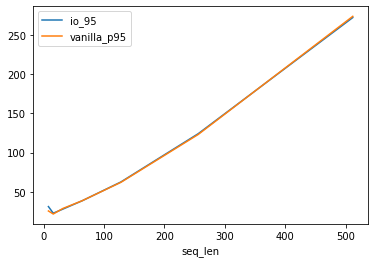

In [32]:
chart_df = pd.merge(df[df.model == 'io'][["seq_len","time_p95_ms"]], df[df.model == 'vanilla'][["seq_len","time_p95_ms"]], on='seq_len')
chart_df = chart_df.rename(columns={"time_p95_ms_x": "io_95", "time_p95_ms_y": "vanilla_p95"})
plt = chart_df.plot(x="seq_len",y=["io_95","vanilla_p95"],kind="line")
plt.figure.savefig('cpu_res.png', dpi=300)


In [33]:
![cpu_res.png](cpu_res.png)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: -c: line 1: syntax error near unexpected token `cpu_res.png'
/bin/bash: -c: line 1: `[cpu_res.png](cpu_res.png)'
